In [2]:
import sqlalchemy as sql
import pandas as pd
import backtrader as bt
import datetime
import yfinance as yf
%matplotlib inline

In [29]:
user = 'USER'
password = 'PASSWD'
host = '192.168.4.114'
db = 'trading_datastore'
engine = sql.create_engine(f"postgresql://{user}:{password}@{host}/{db}")

connection = engine.connect()
metadata = sql.MetaData()
metadata.reflect(bind=engine, views=True)
eod_table = metadata.tables.get('alpha_vantage_equities_eod')
query = sql.select(eod_table).order_by(eod_table.c.date).where(eod_table.c.symbol == 'AAPL')
df  = pd.read_sql(sql=query, con=connection)

In [30]:
df

,date,symbol,open,high,low,close,volume,dividend_amount,split_coefficient
0,1999-11-01,AAPL,80.00,80.690,77.37,77.62,2487300.0,0.0,1.0
1,1999-11-02,AAPL,78.00,81.690,77.31,80.25,3564600.0,0.0,1.0
2,1999-11-03,AAPL,81.62,83.250,81.00,81.50,2932700.0,0.0,1.0
3,1999-11-04,AAPL,82.06,85.370,80.62,83.62,3384700.0,0.0,1.0
4,1999-11-05,AAPL,84.62,88.370,84.00,88.31,3721500.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5659,2022-04-28,AAPL,159.25,164.515,158.93,163.64,130216792.0,0.0,1.0
5660,2022-04-29,AAPL,161.84,166.200,157.25,157.65,131747571.0,0.0,1.0
5661,2022-05-02,AAPL,156.71,158.230,153.27,157.96,123055265.0,0.0,1.0
5662,2022-05-03,AAPL,158.15,160.710,156.32,159.48,88966526.0,0.0,1.0


In [34]:
df = df.set_index(pd.to_datetime(df.date))

In [35]:
df

,date,symbol,open,high,low,close,volume,dividend_amount,split_coefficient
date,,,,,,,,,
1999-11-01,1999-11-01,AAPL,80.00,80.690,77.37,77.62,2487300.0,0.0,1.0
1999-11-02,1999-11-02,AAPL,78.00,81.690,77.31,80.25,3564600.0,0.0,1.0
1999-11-03,1999-11-03,AAPL,81.62,83.250,81.00,81.50,2932700.0,0.0,1.0
1999-11-04,1999-11-04,AAPL,82.06,85.370,80.62,83.62,3384700.0,0.0,1.0
1999-11-05,1999-11-05,AAPL,84.62,88.370,84.00,88.31,3721500.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-04-28,2022-04-28,AAPL,159.25,164.515,158.93,163.64,130216792.0,0.0,1.0
2022-04-29,2022-04-29,AAPL,161.84,166.200,157.25,157.65,131747571.0,0.0,1.0
2022-05-02,2022-05-02,AAPL,156.71,158.230,153.27,157.96,123055265.0,0.0,1.0


In [36]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
                

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 10000.00
1999-11-01, Close, 77.62
1999-11-02, Close, 80.25
1999-11-03, Close, 81.50
1999-11-04, Close, 83.62
1999-11-05, Close, 88.31
1999-11-08, Close, 96.37
1999-11-09, Close, 89.62
1999-11-10, Close, 91.44
1999-11-11, Close, 92.25
1999-11-12, Close, 90.62
1999-11-15, Close, 89.44
1999-11-15, BUY CREATE, 89.44
1999-11-16, BUY EXECUTED, 90.00
1999-11-16, Close, 91.19
1999-11-17, Close, 90.25
1999-11-18, Close, 89.62
1999-11-19, Close, 92.44
1999-11-22, Close, 90.62
1999-11-23, Close, 92.81
1999-11-23, SELL CREATE, 92.81
1999-11-24, SELL EXECUTED, 93.00
1999-11-24, Close, 94.69
1999-11-26, Close, 95.06
1999-11-29, Close, 94.56
1999-11-30, Close, 97.87
1999-12-01, Close, 103.06
1999-12-02, Close, 110.19
1999-12-03, Close, 115.00
1999-12-06, Close, 116.00
1999-12-07, Close, 117.81
1999-12-08, Close, 110.06
1999-12-09, Close, 105.25
1999-12-09, BUY CREATE, 105.25
1999-12-10, BUY EXECUTED, 105.31
1999-12-10, Close, 103.00
1999-12-13, Close, 99.00
1999-12-14, Close

2002-05-23, Close, 25.18
2002-05-24, Close, 24.15
2002-05-24, SELL CREATE, 24.15
2002-05-28, SELL EXECUTED, 23.69
2002-05-28, Close, 23.98
2002-05-28, BUY CREATE, 23.98
2002-05-29, BUY EXECUTED, 23.92
2002-05-29, Close, 23.98
2002-05-30, Close, 24.20
2002-05-31, Close, 23.30
2002-06-03, Close, 22.91
2002-06-04, Close, 22.78
2002-06-05, Close, 22.72
2002-06-05, SELL CREATE, 22.72
2002-06-06, SELL EXECUTED, 22.96
2002-06-06, Close, 22.16
2002-06-06, BUY CREATE, 22.16
2002-06-07, BUY EXECUTED, 21.76
2002-06-07, Close, 21.40
2002-06-10, Close, 21.48
2002-06-11, Close, 20.46
2002-06-12, Close, 20.09
2002-06-13, Close, 19.54
2002-06-14, Close, 20.10
2002-06-14, SELL CREATE, 20.10
2002-06-17, SELL EXECUTED, 20.24
2002-06-17, Close, 20.54
2002-06-18, Close, 20.15
2002-06-19, Close, 17.12
2002-06-19, BUY CREATE, 17.12
2002-06-20, BUY EXECUTED, 17.17
2002-06-20, Close, 17.11
2002-06-21, Close, 16.85
2002-06-24, Close, 17.27
2002-06-25, Close, 17.14
2002-06-26, Close, 16.55
2002-06-27, Close, 17.

2004-04-29, BUY EXECUTED, 26.45
2004-04-29, Close, 26.77
2004-04-30, Close, 25.78
2004-05-03, Close, 26.07
2004-05-04, Close, 26.14
2004-05-05, Close, 26.65
2004-05-06, Close, 26.58
2004-05-06, SELL CREATE, 26.58
2004-05-07, SELL EXECUTED, 26.57
2004-05-07, Close, 26.67
2004-05-10, Close, 26.28
2004-05-11, Close, 27.14
2004-05-12, Close, 27.30
2004-05-13, Close, 27.19
2004-05-14, Close, 27.06
2004-05-14, BUY CREATE, 27.06
2004-05-17, BUY EXECUTED, 26.70
2004-05-17, Close, 26.64
2004-05-18, Close, 27.06
2004-05-19, Close, 26.47
2004-05-20, Close, 26.71
2004-05-21, Close, 27.11
2004-05-24, Close, 27.34
2004-05-24, SELL CREATE, 27.34
2004-05-25, SELL EXECUTED, 27.50
2004-05-25, Close, 28.41
2004-05-26, Close, 28.51
2004-05-27, Close, 28.17
2004-05-28, Close, 28.06
2004-05-28, BUY CREATE, 28.06
2004-06-01, BUY EXECUTED, 27.79
2004-06-01, Close, 28.06
2004-06-02, Close, 28.92
2004-06-03, Close, 28.40
2004-06-04, Close, 28.78
2004-06-07, Close, 29.81
2004-06-08, Close, 30.35
2004-06-08, SELL

2006-04-12, Close, 66.71
2006-04-13, Close, 66.47
2006-04-17, Close, 64.81
2006-04-18, Close, 66.22
2006-04-19, Close, 65.65
2006-04-19, SELL CREATE, 65.65
2006-04-20, SELL EXECUTED, 69.50
2006-04-20, Close, 67.63
2006-04-21, Close, 67.04
2006-04-24, Close, 65.75
2006-04-24, BUY CREATE, 65.75
2006-04-25, BUY EXECUTED, 65.97
2006-04-25, Close, 66.17
2006-04-26, Close, 68.15
2006-04-27, Close, 69.36
2006-04-28, Close, 70.39
2006-05-01, Close, 69.60
2006-05-02, Close, 71.62
2006-05-02, SELL CREATE, 71.62
2006-05-03, SELL EXECUTED, 71.95
2006-05-03, Close, 71.14
2006-05-04, Close, 71.13
2006-05-04, BUY CREATE, 71.13
2006-05-05, BUY EXECUTED, 71.86
2006-05-05, Close, 71.89
2006-05-08, Close, 71.89
2006-05-09, Close, 71.03
2006-05-10, Close, 70.60
2006-05-11, Close, 68.15
2006-05-12, Close, 67.70
2006-05-12, SELL CREATE, 67.70
2006-05-15, SELL EXECUTED, 67.37
2006-05-15, Close, 67.79
2006-05-16, Close, 64.98
2006-05-17, Close, 65.26
2006-05-18, Close, 63.18
2006-05-19, Close, 64.51
2006-05-2

2008-04-10, BUY EXECUTED, 151.13
2008-04-10, Close, 154.55
2008-04-11, Close, 147.14
2008-04-14, Close, 147.78
2008-04-15, Close, 148.38
2008-04-16, Close, 153.70
2008-04-17, Close, 154.49
2008-04-17, SELL CREATE, 154.49
2008-04-18, SELL EXECUTED, 159.04
2008-04-18, Close, 161.04
2008-04-21, Close, 168.16
2008-04-22, Close, 160.20
2008-04-23, Close, 162.89
2008-04-24, Close, 168.94
2008-04-25, Close, 169.73
2008-04-28, Close, 172.24
2008-04-29, Close, 175.05
2008-04-30, Close, 173.95
2008-05-01, Close, 180.00
2008-05-02, Close, 180.94
2008-05-05, Close, 184.73
2008-05-06, Close, 186.66
2008-05-07, Close, 182.59
2008-05-08, Close, 185.06
2008-05-09, Close, 183.45
2008-05-12, Close, 188.16
2008-05-13, Close, 189.96
2008-05-14, Close, 186.26
2008-05-15, Close, 189.73
2008-05-16, Close, 187.62
2008-05-19, Close, 183.60
2008-05-19, BUY CREATE, 183.60
2008-05-20, BUY EXECUTED, 181.83
2008-05-20, Close, 185.90
2008-05-21, Close, 178.19
2008-05-22, Close, 177.05
2008-05-23, Close, 181.17
2008-

2010-08-23, BUY EXECUTED, 251.79
2010-08-23, Close, 245.80
2010-08-24, Close, 239.93
2010-08-25, Close, 242.89
2010-08-26, Close, 240.28
2010-08-27, Close, 241.62
2010-08-30, Close, 242.50
2010-08-30, SELL CREATE, 242.50
2010-08-31, SELL EXECUTED, 241.85
2010-08-31, Close, 243.10
2010-09-01, Close, 250.33
2010-09-02, Close, 252.17
2010-09-03, Close, 258.77
2010-09-07, Close, 257.81
2010-09-08, Close, 262.92
2010-09-09, Close, 263.07
2010-09-10, Close, 263.41
2010-09-13, Close, 267.04
2010-09-14, Close, 268.06
2010-09-15, Close, 270.22
2010-09-16, Close, 276.57
2010-09-17, Close, 275.37
2010-09-20, Close, 283.23
2010-09-21, Close, 283.77
2010-09-22, Close, 287.75
2010-09-23, Close, 288.92
2010-09-24, Close, 292.32
2010-09-27, Close, 291.16
2010-09-28, Close, 286.86
2010-09-28, BUY CREATE, 286.86
2010-09-29, BUY EXECUTED, 287.23
2010-09-29, Close, 287.37
2010-09-30, Close, 283.75
2010-10-01, Close, 282.52
2010-10-04, Close, 278.64
2010-10-05, Close, 288.94
2010-10-06, Close, 289.19
2010-

2012-08-30, BUY EXECUTED, 670.64
2012-08-30, Close, 663.87
2012-08-31, Close, 665.24
2012-09-04, Close, 674.97
2012-09-05, Close, 670.23
2012-09-06, Close, 676.27
2012-09-07, Close, 680.44
2012-09-07, SELL CREATE, 680.44
2012-09-10, SELL EXECUTED, 680.45
2012-09-10, Close, 662.74
2012-09-11, Close, 660.59
2012-09-11, BUY CREATE, 660.59
2012-09-12, BUY EXECUTED, 666.85
2012-09-12, Close, 669.79
2012-09-13, Close, 682.98
2012-09-14, Close, 691.28
2012-09-17, Close, 699.78
2012-09-18, Close, 701.91
2012-09-19, Close, 702.10
2012-09-19, SELL CREATE, 702.10
2012-09-20, SELL EXECUTED, 699.16
2012-09-20, Close, 698.70
2012-09-21, Close, 700.10
2012-09-24, Close, 690.79
2012-09-25, Close, 673.54
2012-09-25, BUY CREATE, 673.54
2012-09-26, BUY EXECUTED, 668.74
2012-09-26, Close, 665.18
2012-09-27, Close, 681.32
2012-09-28, Close, 667.11
2012-10-01, Close, 659.39
2012-10-02, Close, 661.31
2012-10-03, Close, 671.45
2012-10-03, SELL CREATE, 671.45
2012-10-04, SELL EXECUTED, 671.25
2012-10-04, Close

2014-07-15, Close, 95.32
2014-07-16, Close, 94.78
2014-07-16, BUY CREATE, 94.78
2014-07-17, BUY EXECUTED, 95.03
2014-07-17, Close, 93.09
2014-07-18, Close, 94.43
2014-07-21, Close, 93.94
2014-07-22, Close, 94.72
2014-07-23, Close, 97.19
2014-07-24, Close, 97.03
2014-07-24, SELL CREATE, 97.03
2014-07-25, SELL EXECUTED, 96.85
2014-07-25, Close, 97.67
2014-07-28, Close, 99.02
2014-07-29, Close, 98.38
2014-07-30, Close, 98.15
2014-07-30, BUY CREATE, 98.15
2014-07-31, BUY EXECUTED, 97.16
2014-07-31, Close, 95.60
2014-08-01, Close, 96.13
2014-08-04, Close, 95.59
2014-08-05, Close, 95.12
2014-08-06, Close, 94.96
2014-08-07, Close, 94.48
2014-08-07, SELL CREATE, 94.48
2014-08-08, SELL EXECUTED, 94.26
2014-08-08, Close, 94.74
2014-08-11, Close, 95.99
2014-08-12, Close, 95.97
2014-08-13, Close, 97.24
2014-08-14, Close, 97.50
2014-08-15, Close, 97.98
2014-08-18, Close, 99.16
2014-08-19, Close, 100.53
2014-08-20, Close, 100.57
2014-08-21, Close, 100.58
2014-08-22, Close, 101.32
2014-08-25, Close, 

2016-08-12, BUY EXECUTED, 107.78
2016-08-12, Close, 108.18
2016-08-15, Close, 109.48
2016-08-16, Close, 109.38
2016-08-17, Close, 109.22
2016-08-18, Close, 109.08
2016-08-19, Close, 109.36
2016-08-19, SELL CREATE, 109.36
2016-08-22, SELL EXECUTED, 108.86
2016-08-22, Close, 108.51
2016-08-23, Close, 108.85
2016-08-24, Close, 108.03
2016-08-25, Close, 107.57
2016-08-25, BUY CREATE, 107.57
2016-08-26, BUY EXECUTED, 107.41
2016-08-26, Close, 106.94
2016-08-29, Close, 106.82
2016-08-30, Close, 106.00
2016-08-31, Close, 106.10
2016-09-01, Close, 106.73
2016-09-02, Close, 107.73
2016-09-02, SELL CREATE, 107.73
2016-09-06, SELL EXECUTED, 107.90
2016-09-06, Close, 107.70
2016-09-07, Close, 108.36
2016-09-08, Close, 105.52
2016-09-09, Close, 103.13
2016-09-09, BUY CREATE, 103.13
2016-09-12, BUY EXECUTED, 102.65
2016-09-12, Close, 105.44
2016-09-13, Close, 107.95
2016-09-14, Close, 111.77
2016-09-15, Close, 115.57
2016-09-16, Close, 114.92
2016-09-19, Close, 113.58
2016-09-19, SELL CREATE, 113.58

2018-10-08, Close, 223.77
2018-10-09, Close, 226.87
2018-10-10, Close, 216.36
2018-10-11, Close, 214.45
2018-10-12, Close, 222.11
2018-10-15, Close, 217.36
2018-10-15, SELL CREATE, 217.36
2018-10-16, SELL EXECUTED, 218.93
2018-10-16, Close, 222.15
2018-10-17, Close, 221.19
2018-10-18, Close, 216.02
2018-10-18, BUY CREATE, 216.02
2018-10-19, BUY EXECUTED, 218.06
2018-10-19, Close, 219.31
2018-10-22, Close, 220.65
2018-10-23, Close, 222.73
2018-10-24, Close, 215.09
2018-10-25, Close, 219.80
2018-10-26, Close, 216.30
2018-10-26, SELL CREATE, 216.30
2018-10-29, SELL EXECUTED, 219.19
2018-10-29, Close, 212.24
2018-10-29, BUY CREATE, 212.24
2018-10-30, BUY EXECUTED, 211.15
2018-10-30, Close, 213.30
2018-10-31, Close, 218.86
2018-11-01, Close, 222.22
2018-11-02, Close, 207.48
2018-11-05, Close, 201.59
2018-11-06, Close, 203.77
2018-11-06, SELL CREATE, 203.77
2018-11-07, SELL EXECUTED, 205.97
2018-11-07, Close, 209.95
2018-11-08, Close, 208.49
2018-11-09, Close, 204.47
2018-11-09, BUY CREATE, 

2021-02-01, Close, 134.14
2021-02-02, Close, 134.99
2021-02-03, Close, 133.94
2021-02-04, Close, 137.39
2021-02-05, Close, 136.76
2021-02-05, SELL CREATE, 136.76
2021-02-08, SELL EXECUTED, 136.03
2021-02-08, Close, 136.91
2021-02-09, Close, 136.01
2021-02-10, Close, 135.39
2021-02-10, BUY CREATE, 135.39
2021-02-11, BUY EXECUTED, 135.90
2021-02-11, Close, 135.13
2021-02-12, Close, 135.37
2021-02-16, Close, 133.19
2021-02-17, Close, 130.84
2021-02-18, Close, 129.71
2021-02-19, Close, 129.87
2021-02-19, SELL CREATE, 129.87
2021-02-22, SELL EXECUTED, 128.01
2021-02-22, Close, 126.00
2021-02-23, Close, 125.86
2021-02-23, BUY CREATE, 125.86
2021-02-24, BUY EXECUTED, 124.94
2021-02-24, Close, 125.35
2021-02-25, Close, 120.99
2021-02-26, Close, 121.26
2021-03-01, Close, 127.79
2021-03-02, Close, 125.12
2021-03-03, Close, 122.06
2021-03-03, SELL CREATE, 122.06
2021-03-04, SELL EXECUTED, 121.75
2021-03-04, Close, 120.13
2021-03-04, BUY CREATE, 120.13
2021-03-05, BUY EXECUTED, 120.98
2021-03-05, 

<IPython.core.display.Javascript object>


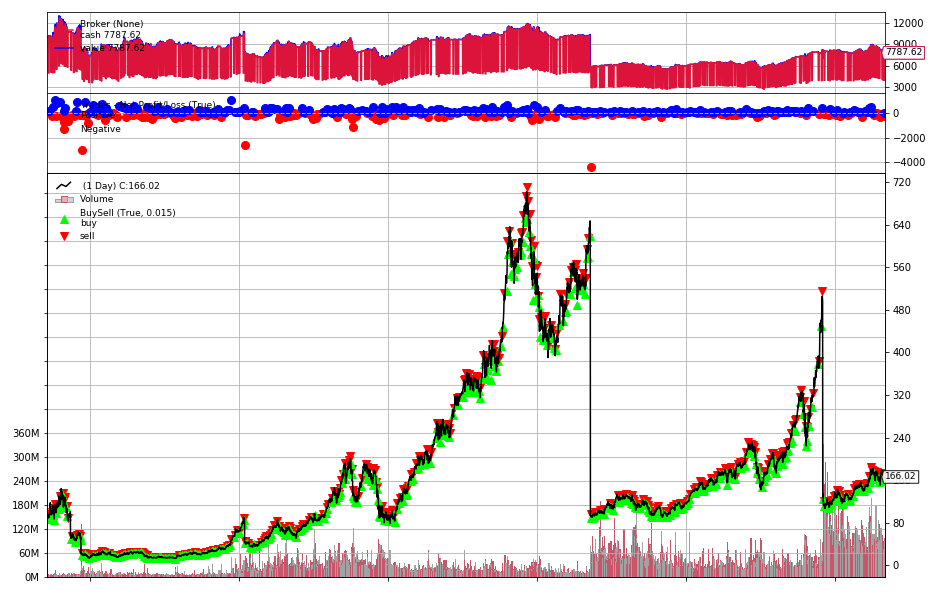

OrderedDict([(1999, 0.016682977985459813),
             (2000, -0.26988957737799046),
             (2001, 0.26304736446815813),
             (2002, -0.020907920570029548),
             (2003, -0.08264233346475025),
             (2004, 0.1899623163088493),
             (2005, -0.0781444082077748),
             (2006, -0.06529627034954322),
             (2007, 0.14241442854437114),
             (2008, -0.2840302103304351),
             (2009, 0.3910564905941827),
             (2010, -0.017970107609173946),
             (2011, 0.06100731242450119),
             (2012, 0.09024080123773803),
             (2013, -0.09437308005815037),
             (2014, -0.398369256649144),
             (2015, -0.037409166007988603),
             (2016, 0.016536841611288988),
             (2017, 0.06237101859273042),
             (2018, -0.10079807355404835),
             (2019, 0.2743551549846681),
             (2020, 0.11669721364823205),
             (2021, 0.09606358998825493),
             (2022, -0.12

In [37]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)


#Add data feed to cerebro
feed = bt.feeds.PandasData(dataname=df)
cerebro.adddata(feed)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Set the commission
cerebro.broker.setcommission(commission=0.001)

#add sizer 50% of the whole portoflio
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

#add annual return analyzer
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strategy_res = cerebro.run()

#Plot out the back testing results
cerebro.plot()

#Show annual return
strategy_res[0].analyzers.annual_return.get_analysis()